In [1]:
import numpy as np

import matplotlib.pyplot as plt

import subprocess

import time
from datetime import datetime 

In [2]:
offset = 8000e6 # if 1MHz is used for data out of RFspace device than offset = rx_frequency - 1000000 
siteid = 8049 #COSPAR station ID for site.txt in strf

# IF bandwidth filter limits to remove bad data outside expected range.
bw_upper = 1003000
bw_lower = 998000

In [3]:
def unixtojulian(unix):
    return((unix / 86400) + 2440587.5) # convert unix timestamp to julian date

def juliantomjd(julian):
    return(julian - 2400000.5) #convert julian date to MJD

def unixutc(data):
    return(time.mktime(data.timetuple()) - time.timezone) #figure out local timezone and return offset.

def readSVdata(data):
    ncols = 5
    recordarr = np.rec.array(np.genfromtxt(data, usecols=(0,1,2,3,4), dtype=[('d','<S12'), ('t', '<S10'),('freq', '<i4'),('level', '<f2'),('db', '<S2')], delimiter=None, invalid_raise=False)) #invalid_raise allows you to view data with some errors in the file, typically incomplete table issues at EOF.
    return(recordarr)


In [4]:
svdata = readSVdata("271020peakreclog.txt")
 
output = np.zeros(len(svdata), dtype=[('dt_out', '<f8'), ('freq_out', '<i8'), ('db_out', '<f2'), ('stn_out', '<i2')])
outputrec = np.rec.array(output)

print (svdata[0]['freq'])



i = 0
while i < len(svdata):
    dt_str = svdata[i]['d'].decode('UTF-8') + " " + svdata[i]['t'].decode('UTF-8') 
    #dt_str = svdata[i]['d'] + svdata[i]['t']
    dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')   
    outputrec[i].dt_out = juliantomjd(unixtojulian(unixutc(dt)))  
    outputrec[i].freq_out = svdata[i].freq + offset  
    outputrec[i].db_out = svdata[i].level
    outputrec[i].stn_out = siteid
            
    i += 1
    

430714949


In [5]:
print (min(outputrec.dt_out))
print (max(outputrec.dt_out))


59149.670949073974
59149.9269212964


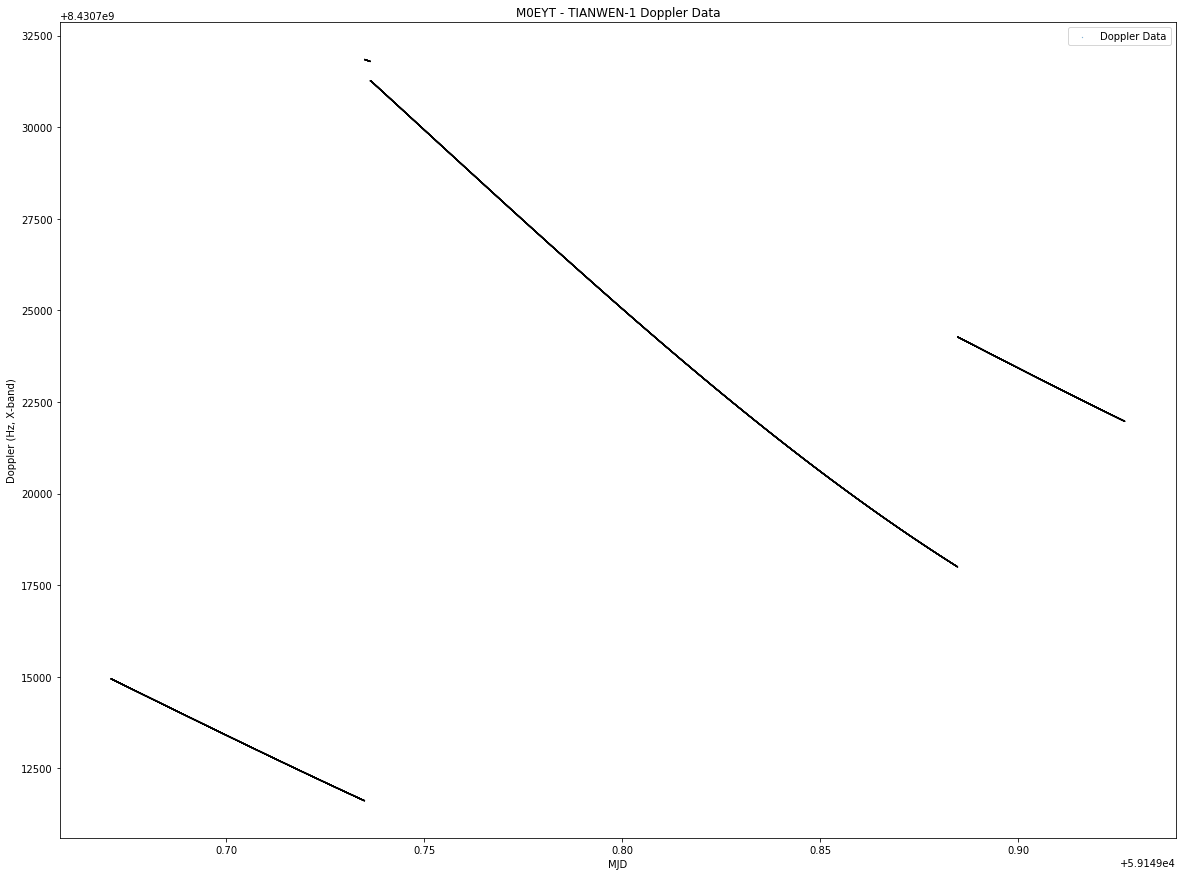

In [6]:
fig_size = [20, 15]
plt.rcParams['figure.figsize'] = fig_size

#plt.plot(outputrec['dt_out'],outputrec['freq_out'], '.', markersize = .1)
plt.scatter(outputrec['dt_out'],outputrec['freq_out'],c=outputrec['db_out'], cmap='binary', marker='.', vmin=-104, vmax=-62, s=0.2 )
#plt.scatter(58488.65763, 2235496275, marker='|', s=5000, color='green')
#plt.scatter(58488.72013, 2235498250, marker='|', s=5000, color='red')
#plt.gray()
plt.title('M0EYT - TIANWEN-1 Doppler Data')
plt.xlabel('MJD')
plt.ylabel('Doppler (Hz, X-band)')
plt.legend(['Doppler Data']);
plt.show()


In [7]:
np.savetxt('mydata.dat', outputrec, fmt=('%f','%f','%f','%i'), delimiter='\t') #save data into strf compatible .dat file.